In [1]:
import requests
import pandas as pd
import networkx as nx
import numpy as np

import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials #To access authorised Spotify data

import time
import random

import matplotlib
import matplotlib.pyplot as plt

In [2]:
ARTIST = "Adele"

### API keys and main parameters

SetList.fm

In [3]:
API_KEY = "ad30e075-cc83-41c3-8708-dfb5625a2330"

BASE_URL = "https://api.setlist.fm/rest/1.0"
MIN_SETLIST_LEN = 5
NUM_OF_PAGES = 6

Spotify

In [4]:
client_id = '1f9afb3cf4f444d3b3a2f9d3bf20a4dc'
client_secret = '12f145a677b54fe6b6b05c52dcbd433b'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

## SPOTIFY FUNCTIONS

In [37]:
def get_uri_song_art(song, artist):
    for it in sp.search(song)['tracks']['items']:
        if it['artists'][0]['name'].lower() == artist.lower():
            return it['uri']
    return None

In [39]:
def get_popularity_song_art(song, artist):
    for it in sp.search(song)['tracks']['items']:
        if it['artists'][0]['name'].lower() == artist.lower():
            return it['popularity'], it['uri']
    return 0, 0

In [36]:
get_popularity_song_art('hello','adele')

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])


71

In [6]:
def get_artist_picture(NAME):
    result = sp.search(NAME) #search query
    #Extract Artist's uri
    artist_uri = [x['uri'] for x in result['tracks']['items'][0]['artists'] if x['name'].lower() == NAME.lower()][0]
    return sp.artist(artist_uri)['images'][0]['url']


In [7]:
get_artist_picture('The killers')

'https://i.scdn.co/image/a841f0ee4f2d88c42f55f76c2cc6b588841f5d2f'

In [8]:
def get_albums_info(sp_albums):
    album_names = []
    album_uris = []
    for i in range(len(sp_albums['items'])):
        album_names.append(sp_albums['items'][i]['name'])
        album_uris.append(sp_albums['items'][i]['uri'])
    return album_names, album_uris

In [9]:
def albumSongs(uri, name, spotify_albums):
    album = uri #assign album uri to a_name
    spotify_albums[album] = {} #Creates dictionary for that specific album
    #Create keys-values of empty lists inside nested dictionary for album
    spotify_albums[album]['album'] = [] #create empty list
    spotify_albums[album]['track_number'] = []
    spotify_albums[album]['id'] = []
    spotify_albums[album]['name'] = []
    spotify_albums[album]['uri'] = []
    tracks = sp.album_tracks(album) #pull data on album tracks
    for n in range(len(tracks['items'])): #for each song track
            spotify_albums[album]['album'].append(name) #append album name tracked via album_count
            spotify_albums[album]['track_number'].append(tracks['items'][n]['track_number'])
            spotify_albums[album]['id'].append(tracks['items'][n]['id'])
            spotify_albums[album]['name'].append(tracks['items'][n]['name'])
            spotify_albums[album]['uri'].append(tracks['items'][n]['uri'])
    return spotify_albums

In [10]:
def get_artist_info(NAME):
    result = sp.search(NAME) #search query
    #Extract Artist's uri
    artist_uri = [x['uri'] for x in result['tracks']['items'][0]['artists'] if x['name'].lower() == NAME.lower()][0]

    #Pull all of the artist's albums
    sp_albums = sp.artist_albums(artist_uri, album_type='album')
    album_names, album_uris = get_albums_info(sp_albums)

    spotify_albums = {}
    album_count = 0
    checked_albs = []
    for i, name in zip(album_uris, album_names): #each album
        if name not in checked_albs:
            checked_albs.append(name)
            spotify_albums = albumSongs(i, name, spotify_albums)
            album_count+=1 #Updates album count once all tracks have been addedb
  
    return spotify_albums

In [11]:
def audio_features(album):
    #Add new key-values to store audio features
    album['popularity'] = []
    #create a track counter
    track_count = 0
    for track in album['uri']:
        #pull audio features per track
        features = sp.audio_features(track)
        pop = sp.track(track)
        album['popularity'].append(pop['popularity'])
        track_count+=1

In [12]:
def info_pd(spotify_albums):
    sleep_min = 2
    sleep_max = 5
    start_time = time.time()
    request_count = 0


    for i in spotify_albums:
        audio_features(spotify_albums[i])
        request_count+=1
        if request_count % 5 == 0:
            print(str(request_count) + " playlists completed")
            time.sleep(np.random.uniform(sleep_min, sleep_max))
    dic_df = {}
    dic_df['album'] = []
    dic_df['track_number'] = []
    dic_df['id'] = []
    dic_df['name'] = []
    dic_df['uri'] = []
    dic_df['popularity'] = []
    for album in spotify_albums: 
        for feature in dic_df.keys():
            dic_df[feature].extend(spotify_albums[album][feature])

    artist_df = pd.DataFrame.from_dict(dic_df)
    artist_df['name'] = artist_df['name'].apply(lambda x: x.lower())
    return artist_df

## CONCERT INFO FUNCTIONS

In [13]:
def get_setlist_songs(ARTIST, BASE_URL, API_KEY):
    artist_url = "{}/search/artists/?sort=relevance&artistName={}".format(BASE_URL, ARTIST)
    headers = {'x-api-key': API_KEY, 'Accept': 'application/json'}
    r = requests.get(artist_url, headers=headers)
    artists = r.json().get('artist')
    artist = artists[0]
    responses = []
    for i in range(1, NUM_OF_PAGES): 
        playlist_url = "{}/artist/{}/setlists/?p={}".format(BASE_URL, artist.get('mbid'), i)
        r = requests.get(playlist_url, headers=headers)
        responses.append(r.json())

        
    responses_setlist = map(lambda x: x.get('setlist'), responses)
    flattened_setlists = [item for sublist in responses_setlist for item in sublist if 'tour' in item.keys()]

    cleaned_setlists = list(map(lambda x: {
        'eventDate': x.get('eventDate'), 
        'songs': list(map(lambda z: z.get('name'), \
        [item for sublist in map(lambda y: y.get('song'), x.get('sets').get('set')) for item in sublist])) \
        , 
        'tour': x.get('tour').get('name'),
        'country': x.get('venue').get('city').get('country').get('code')
        }, flattened_setlists))
    
    cleaned_setlists = [x for x in cleaned_setlists if 'songs' in x.keys()]
    cleaned_setlists = [x for x in cleaned_setlists if len(x['songs']) > 5]
    only_songs = list(map(lambda x: ["begin"] + x.get('songs') + ["end"], cleaned_setlists))
    
    return cleaned_setlists, only_songs

In [14]:
def song_list_to_df(ARTIST, BASE_URL, API_KEY):
    cleaned_list, songs = get_setlist_songs(ARTIST, BASE_URL, API_KEY)
    pairs = []
    for concert in cleaned_list:
        setlist = concert['songs']
        setlist = ['begin'] + setlist + ['end']
        for i in range(len(setlist) - 1):
            pairs.append((setlist[i], setlist[i+1], concert['tour'], concert['country'], concert['eventDate']))

    df_pairs = pd.DataFrame(pairs)

    df_pairs = df_pairs.rename(columns={0:'song_org', 1:'next_song', 2:'tour', 3:'country', 4:'date'})
    the_tour = df_pairs.sort_values(by=['date']).iloc[0]['tour']
    df_pairs2 = df_pairs[df_pairs.tour == the_tour]
    
    length_concert = df_pairs.groupby('date').count().median()['song_org']
    b = df_pairs2.groupby('date').count()
    dates = b[(b.song_org < length_concert + 2) & (b.song_org > length_concert - 2) ].index
    
    df_pairs2 = df_pairs2[df_pairs.date.isin(dates)].groupby(['song_org', 'next_song']).size().reset_index().rename(columns={0:'weight'})
    
    return df_pairs, df_pairs2

### GET CONCERT INFO

In [32]:
info_complete

,song_org,next_song,tour,country,date
0,begin,Hello,Adele Live 2016/17,GB,29-06-2017
1,Hello,Hometown Glory,Adele Live 2016/17,GB,29-06-2017
2,Hometown Glory,One and Only,Adele Live 2016/17,GB,29-06-2017
3,One and Only,I'll Be Waiting,Adele Live 2016/17,GB,29-06-2017
4,I'll Be Waiting,Rumour Has It,Adele Live 2016/17,GB,29-06-2017
...,...,...,...,...,...
1750,Someone Like You,Set Fire to the Rain,Adele Live 2016/17,NO,01-05-2016
1751,Set Fire to the Rain,All I Ask,Adele Live 2016/17,NO,01-05-2016
1752,All I Ask,When We Were Young,Adele Live 2016/17,NO,01-05-2016
1753,When We Were Young,Rolling in the Deep,Adele Live 2016/17,NO,01-05-2016


In [15]:
info_complete, df_pairs = song_list_to_df(ARTIST, BASE_URL, API_KEY)

In [17]:
def get_statistics(info_complete):
    stats = {}
    first_song = info_complete[info_complete.song_org == 'begin'].groupby('next_song').count().\
                sort_values(by=['song_org']).reset_index()
    most_played = info_complete[['song_org', 'next_song']].groupby('next_song').count().\
                sort_values(by='song_org').reset_index()
    
    last_song = info_complete[info_complete.next_song == 'end'].groupby('song_org').count().\
                sort_values(by=['next_song']).reset_index()
    stats['first_song'] = first_song.iloc[-1].next_song
    stats['top_three'] = list(most_played[most_played['next_song'] != 'end'].iloc[-3:]['next_song'].unique()[::-1])
    stats['most_played'] = most_played[most_played['next_song'] != 'end'].iloc[-1]['next_song']
    stats['last_song'] = last_song.iloc[-1].song_org
    
    return stats
    
    

In [18]:
statistics = get_statistics(info_complete)

In [19]:
statistics

{'first_song': 'Hello',
 'top_three': ['Send My Love (to Your New Lover)', 'Hello', 'Hometown Glory'],
 'most_played': 'Send My Love (to Your New Lover)',
 'last_song': 'Rolling in the Deep'}

### GET SPOTIFY INFO

In [33]:
spotify_albums = get_artist_info(ARTIST)
pd_artist = info_pd(spotify_albums)

In [34]:
pd_artist

,album,track_number,id,name,uri,popularity
0,25,1,4sPmO7WMQUAf45kwMOtONw,hello,spotify:track:4sPmO7WMQUAf45kwMOtONw,71
1,25,2,4BHzQ9C00ceJxfG16AlNWb,send my love (to your new lover),spotify:track:4BHzQ9C00ceJxfG16AlNWb,70
2,25,3,0QLXkoV7vX86QEibgLe6zQ,i miss you,spotify:track:0QLXkoV7vX86QEibgLe6zQ,60
3,25,4,7IWkJwX9C0J7tHurTD7ViL,when we were young,spotify:track:7IWkJwX9C0J7tHurTD7ViL,72
4,25,5,7GgQi7JTG4b6J4iEF4RTjF,remedy,spotify:track:7GgQi7JTG4b6J4iEF4RTjF,62
5,25,6,4vb4mFvYsr2h6enhjJsq9Y,water under the bridge,spotify:track:4vb4mFvYsr2h6enhjJsq9Y,66
6,25,7,60jkAyuEyOnQKlrppOTYYx,river lea,spotify:track:60jkAyuEyOnQKlrppOTYYx,58
7,25,8,6oQRvWaoFDJpTTnaWdzhXt,love in the dark,spotify:track:6oQRvWaoFDJpTTnaWdzhXt,57
8,25,9,5VwSwu1zeiMGAjwe9nUmzZ,million years ago,spotify:track:5VwSwu1zeiMGAjwe9nUmzZ,61
9,25,10,1wMALZpuqAy7amQsFBWQ8m,all i ask,spotify:track:1wMALZpuqAy7amQsFBWQ8m,69


In [ ]:
length_concert = info_complete.groupby('date').count().median()['song_org']

## CREATE GRAPH AND GET PLAYLIST

In [20]:
G = nx.from_pandas_edgelist(df_pairs, 'song_org', 'next_song', ['weight'], create_using=nx.DiGraph())

In [23]:
def get_playlist(G, source='begin', target='end'):
    visited = []
    cur = source

    while cur != target:
        visited.append(cur)
        weights = []
        neighs = []
        for n in G.neighbors(cur):
            if n not in visited:
                weights.append(np.exp(G.get_edge_data(cur, n).get('weight')))
                neighs.append(n)
        weights = np.asarray(weights)/sum(weights)
        if len(weights) == 0:
            cur = target
        else:
            cur = np.random.choice(neighs, 1,
                      p=weights)[0]
        
    return visited

In [25]:
playlist_go = get_playlist(G)

In [26]:
playlist_go

['begin',
 'Hello',
 'Hometown Glory',
 'One and Only',
 'Rumour Has It',
 'Water Under the Bridge',
 'I Miss You',
 'Skyfall',
 'Million Years Ago',
 "Don't You Remember",
 'Make You Feel My Love',
 'Send My Love (to Your New Lover)',
 'Sweetest Devotion',
 'Chasing Pavements',
 'Someone Like You',
 'Set Fire to the Rain',
 'When We Were Young',
 'Rolling in the Deep']

## VISUALIZE RESULTS

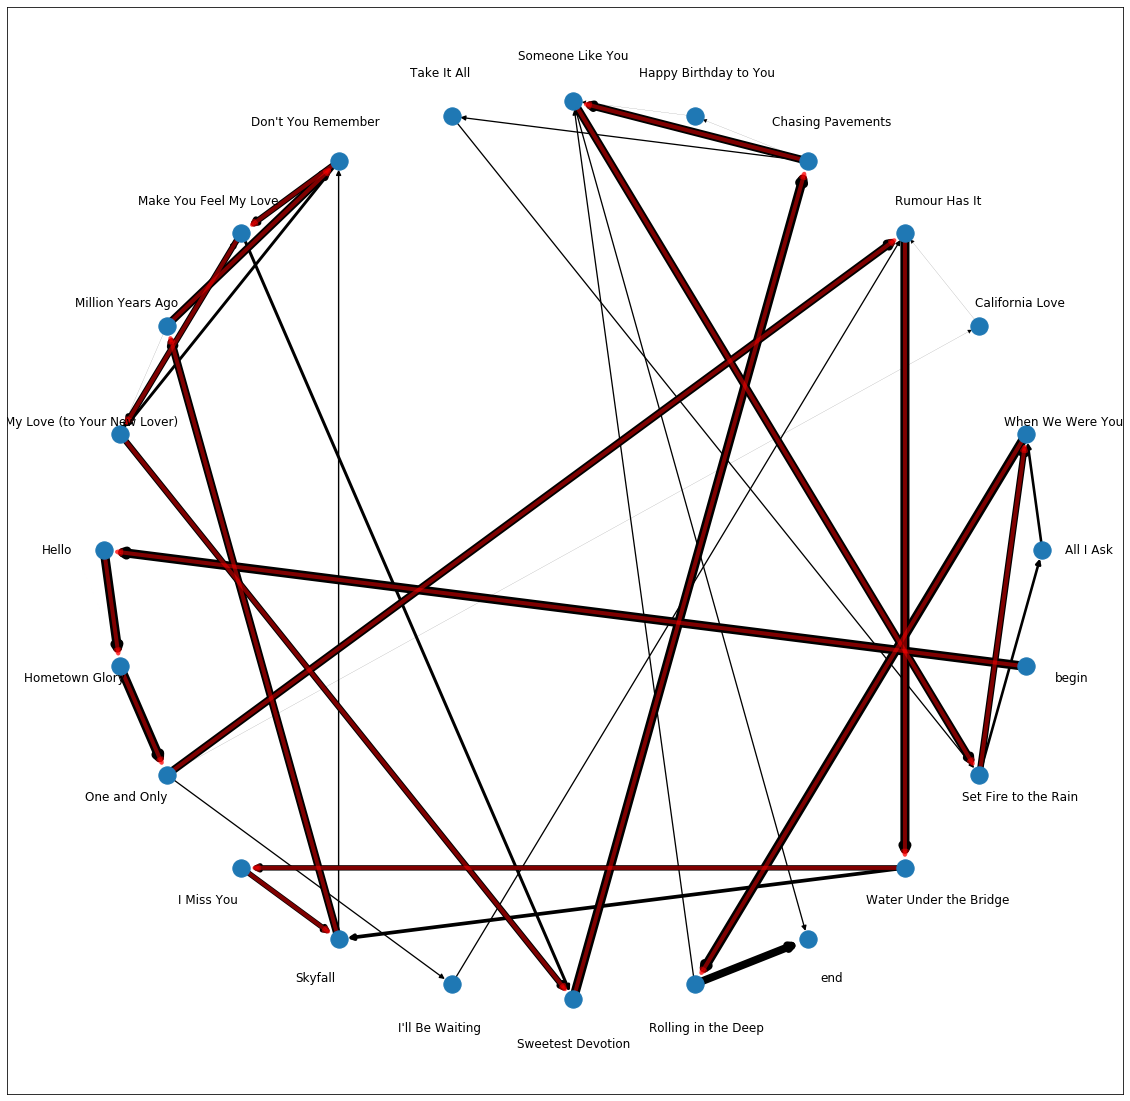

In [27]:
all_weights = []

f, ax = plt.subplots(figsize=(20,20))
pos=nx.circular_layout(G)
pos_higher = {}
for k, v in pos.items():
    pos_higher[k] = (v[0]*1.1, v[1]*1.1)
    
nx.draw_networkx_nodes(G.nodes, pos=pos)
nx.draw_networkx_labels(G, pos=pos_higher)
colors = ['r', 'b', 'y']
edges_1 = []
edges_2 = []
for i in range(len(playlist_go) - 1):
    edges_1.append((playlist_go[i], playlist_go[i+1]))

for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight'])

unique_weights = list(set(all_weights))

for weight in unique_weights:
    #4 d. Form a filtered list with just the weight you want to draw
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    width = weight*0.1
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='k', ax=ax)
    

for ctr, edges_l in enumerate([edges_1]):
    nx.draw_networkx_edges(G,pos=pos, edgelist=edges_l, edge_color = colors[ctr], style='dashed', ax=ax, width=4, alpha=0.5)


#plt.savefig('graph_song_{}'.format(ARTIST),bbox_inches = 'tight',
#    pad_inches = 0)

In [30]:
from bokeh.io import show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

In [31]:
plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
              tools="", toolbar_location=None)

plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())

graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)

In [40]:
a = ['A', 'B', 4]

In [41]:
a.append(None)

In [42]:
a

['A', 'B', 4, None]

In [43]:
if None:
    print('hi')
else:
    print('xaxi')

xaxi
